In [1]:
import os
import sys
notebook_directory = os.getcwd()
sys.path.append(notebook_directory)
import ExpTime_Calc as EC

In [2]:
# Initialize the SED class
model = EC.SED(mag = 20, temperature = 9700)

# Create the spectrum
wavelength,spectrum = model.photon_spectrum()

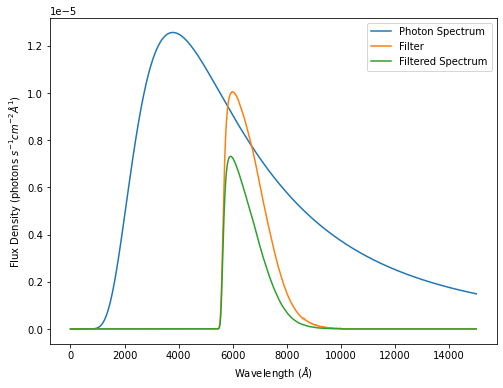

In [3]:
# Initialize the BandPass class
Vband = EC.BandPass('R')

# Filter the spectrum with the filter response
filtered_spectrum = Vband.filter_SED(wavelength, spectrum,plot=True)

In [22]:
model_SED = EC.SED(mag = 20, temperature = 9700)

timstelescope = EC.Telescope(diameter=60,diameter_units='cm',focal_length=600,foc_len_units='mm') #create telescope

LasCruces = EC.atmosphere('default',seeing=1) #create atmosphere conditions

camera = EC.detector('$$$') #create detector

In [23]:
observation = EC.Observation(model_SED,                              #initialize observation
                              filter='V',telescope=timstelescope,
                              atmosphere=LasCruces,detector=camera)

In [24]:
observation.total_skyglow

0.15191719104094514

10.5 photons per second
 
967.0990559586605 seconds for SNR=100


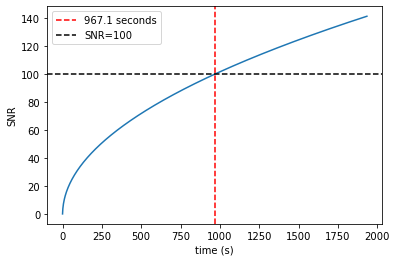

In [25]:
snr = EC.Signal_to_Noise(observation,SNR=100)

time = snr.calc_exptime(plot=True)